In [2]:
%load_ext autoreload
%autoreload 2

from hmmlearn import hmm
import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Naive HMM

Assume the signal follows a normal distribution 

$$
\begin{aligned}
    y(t) \sim \mathcal{N}(\mu_{x(t)}, \sigma_{x(t)}^2)
\end{aligned}
$$

In below model we encode a state, $x$, for each fuel type.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/8/83/Hmm_temporal_bayesian_net.svg/1920px-Hmm_temporal_bayesian_net.svg.png)

In [4]:
# The states.
STATES = ['hfo', 'mgo', 'ulsfo', 'vlsfo']

# The dirchlett prior probabilities for each state.
# Reference: https://en.wikipedia.org/wiki/Dirichlet_distribution
PRIOR_PROBABILITY = {
    'hfo': 0.8,
    'mgo': 0.1,
    'ulsfo': 0.05,
    'vlsfo': 0.05,
}

# Saved as from -> to.
TRANSITION_PROBABILITY = {
    'hfo': 
        {'hfo': 0.85, 'mgo': 0.05, 'ulsfo': 0.05, 'vlsfo': 0.05},
    'mgo': 
        {'hfo': 0.1, 'mgo': 0.9, 'ulsfo': 0.0, 'vlsfo': 0.0},
    'ulsfo': 
        {'hfo': 0.1, 'mgo': 0.0, 'ulsfo': 0.9, 'vlsfo': 0.0},
    'vlsfo': 
        {'hfo': 0.1, 'mgo': 0.0, 'ulsfo': 0.0, 'vlsfo': 0.9},
}

# The distribution of the emmision for each state.
DENSITY_DISTRIBUTION = {
    'hfo': 
        {'mu': 1010, 'sigma': 100},
    'mgo': 
        {'mu': 900, 'sigma': 25},
    'ulsfo': 
        {'mu': 905, 'sigma': 25},
    'vlsfo': 
        {'mu': 910, 'sigma': 25},
}

for from_ in TRANSITION_PROBABILITY:
    assert sum(TRANSITION_PROBABILITY[from_].values()) == 1.0, (
        f'{from_} transition probabilities does not sum to 1.0.'
    )

In [5]:
np.random.seed(42)

model = hmm.GaussianHMM(
    n_components = len(STATES),
    covariance_type = "full"
)
model.n_features = 1  # If not set then one can't call model.covars_ after.

model.startprob_ = np.array([
    PRIOR_PROBABILITY[state] for state in STATES
])

model.transmat_ = np.array([
    [TRANSITION_PROBABILITY[from_][to] for to in STATES] for from_ in STATES
])

model.means_ = np.array([
    [DENSITY_DISTRIBUTION[state]['mu']] for state in STATES
])

model.covars_ = np.array([
    [[DENSITY_DISTRIBUTION[state]['sigma']]] for state in STATES
])


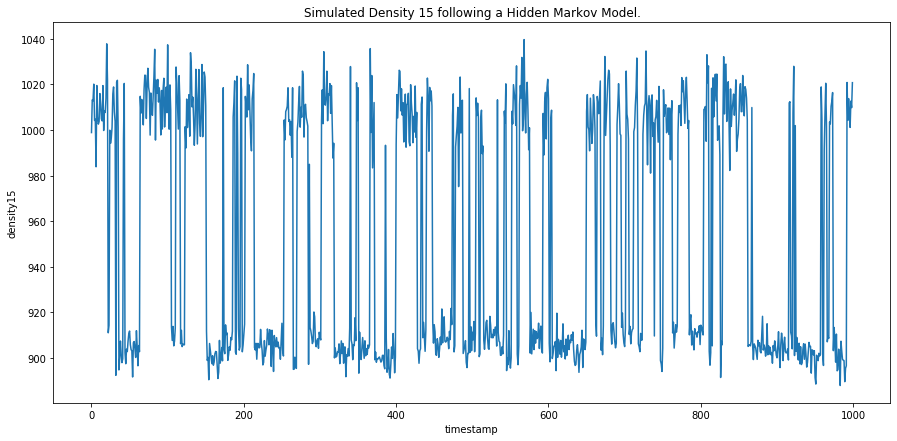

In [6]:
Y, X = model.sample(1000)
plt.figure(figsize=(15, 7))
plt.plot(Y)
plt.ylabel('density15')
plt.xlabel('timestamp')
_ = plt.title('Simulated Density 15 following a Hidden Markov Model.')

# Steady and Changeover States

Assume steady states where 

$$
\begin{aligned}
    y(t) & \sim \mathcal{N}(\mu_{x(t)}, \sigma_{x(t)}^2)
\end{aligned}
$$

AND changeover states where

$$
\begin{aligned}
    y(t) & \sim \mathcal{N}(\mu_{x(t-1)}\exp(-\alpha), \sigma_{x(t)}^2)
\end{aligned}
$$

where $\alpha = \frac{1}{\Delta}\log\frac{\mu_{from}}{\mu_{to}} \Leftrightarrow \Delta = \frac{1}{\alpha}\log\frac{\mu_{from}}{\mu_{to}} \Leftrightarrow \mu_{to} = \mu_{from}\cdot \exp(-\Delta \alpha)$, $\Delta$ is the number of transition steps. Create a state for each transition step. 

![](https://upload.wikimedia.org/wikipedia/commons/thumb/8/83/Hmm_temporal_bayesian_net.svg/1920px-Hmm_temporal_bayesian_net.svg.png)

In [7]:
# The states.
STEADY_STATES = ['hfo', 'mgo', 'ulsfo', 'vlsfo']
DELTA = 100
CHANGEOVER_STATES = [f'hfo -> mgo {round((i + 1) / DELTA, 4)}' for i in range(DELTA)]
STATES = STEADY_STATES + CHANGEOVER_STATES 

# The dirchlett prior probabilities for each state.
# Reference: https://en.wikipedia.org/wiki/Dirichlet_distribution
PRIOR_PROBABILITY = {
    'hfo': 0.75,
    'mgo': 0.1,
    'ulsfo': 0.05,
    'vlsfo': 0.05,
    **{f'hfo -> mgo {round((i + 1) / DELTA, 4)}': 0.05 / DELTA for i in range(DELTA)}
}


# Saved as from -> to.
ZERO_PROB_TRANSITION = {
    f'hfo -> mgo {round((i + 1) / DELTA, 4)}': 0
    for i in range(DELTA)
}
NON_ZERO_PROB_TRANSITION = {
    f'hfo -> mgo {round((i + 1) / DELTA, 4)}': 0.05 if i == 0 else 0
    for i in range(DELTA)
}
STEADY_TRANSITION_PROBABILITY = {
    'hfo': {
        'hfo': 0.85, 'mgo': 0.0, 'ulsfo': 0.05, 'vlsfo': 0.05,
        **NON_ZERO_PROB_TRANSITION
    },
    'mgo': {
        'hfo': 0.1, 'mgo': 0.9, 'ulsfo': 0.0, 'vlsfo': 0.0,
        **ZERO_PROB_TRANSITION
    },
    'ulsfo': {
        'hfo': 0.1, 'mgo': 0.0, 'ulsfo': 0.9, 'vlsfo': 0.0,
        **ZERO_PROB_TRANSITION
    },
    'vlsfo': {
        'hfo': 0.1, 'mgo': 0.0, 'ulsfo': 0.0, 'vlsfo': 0.9,
        **ZERO_PROB_TRANSITION
    }
}
CHANGEOVER_TRANSITION_PROBABILITY = {
    changeover_state: {
        state: 0.0 if state != next_changeover_state else 1.0
        for state in STATES
    } 
    for changeover_state, next_changeover_state in 
    zip(CHANGEOVER_STATES, CHANGEOVER_STATES[1:] + ['mgo'])
}
TRANSITION_PROBABILITY = {
    **STEADY_TRANSITION_PROBABILITY,
    **CHANGEOVER_TRANSITION_PROBABILITY
}

# The distribution of the emmision for each state.
STEADY_DENSITY_DISTRIBUTION = {
    'hfo': 
        {'mu': 1010, 'sigma': 100},
    'mgo': 
        {'mu': 900, 'sigma': 25},
    'ulsfo': 
        {'mu': 905, 'sigma': 25},
    'vlsfo': 
        {'mu': 910, 'sigma': 25},
}

CHANGEOVER_DENSITY_DISTRIBUTION = {}
mu_t_1 = STEADY_DENSITY_DISTRIBUTION['hfo']['mu']
alpha =(1 / DELTA) * np.log(
    STEADY_DENSITY_DISTRIBUTION['hfo']['mu'] / STEADY_DENSITY_DISTRIBUTION['mgo']['mu']
)
for idx, changeover_state in enumerate(CHANGEOVER_STATES):
    mu_t_1 = mu_t_1 * np.exp(- alpha)
    CHANGEOVER_DENSITY_DISTRIBUTION[changeover_state] = {
        'mu': mu_t_1, 'sigma': 50
    }
DENSITY_DISTRIBUTION = {
    **STEADY_DENSITY_DISTRIBUTION,
    **CHANGEOVER_DENSITY_DISTRIBUTION
} 

def to_state(x):
    """Convert a x (state encoded as 1, 2, 3, ...) to a state."""
    return dict(zip(range(len(STATES)), STATES))[x]
    

def get_from_to(changeover_state):
    """Get the from -> to states from a changeover state."""
    from_, _, to = changeover_state.split()
    return from_, to

for from_ in TRANSITION_PROBABILITY:
    assert sum(TRANSITION_PROBABILITY[from_].values()) == 1.0, (
        f'{from_} transition probabilities does not sum to 1.0.'
    )

In [8]:
np.random.seed(42)

model = hmm.GaussianHMM(
    n_components = len(STATES),
    covariance_type = "full"
)
model.n_features = 1  # If not set then one can't call model.covars_ after.

model.startprob_ = np.array([
    PRIOR_PROBABILITY[state] for state in STATES
])

model.transmat_ = np.array([
    [TRANSITION_PROBABILITY[from_][to] for to in STATES] for from_ in STATES
])

model.means_ = np.array([
    [DENSITY_DISTRIBUTION[state]['mu']] for state in STATES
])

model.covars_ = np.array([
    [[DENSITY_DISTRIBUTION[state]['sigma']]] for state in STATES
])


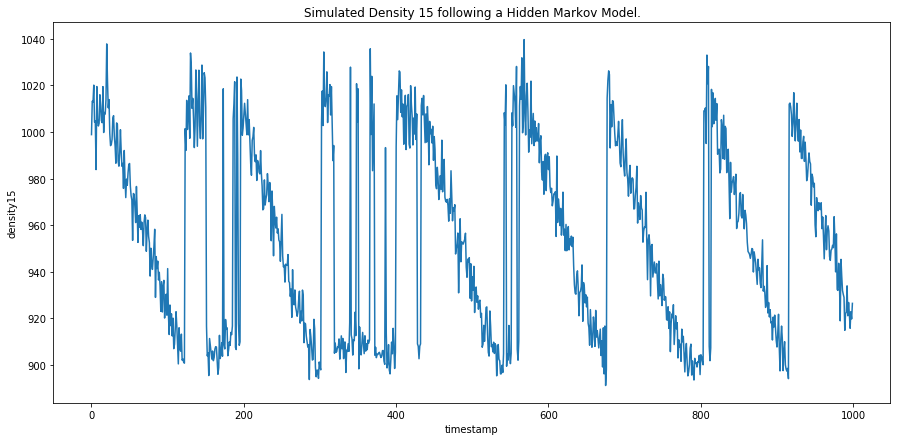

In [9]:
Y, X = model.sample(1000)
plt.figure(figsize=(15, 7))
plt.plot(Y)
plt.ylabel('density15')
plt.xlabel('timestamp')
_ = plt.title('Simulated Density 15 following a Hidden Markov Model.')

#### Conclusion:

Might be too computationally expensive to encode all transitions as states. Takes a long time to encode just one rate of changeover ($\alpha$). The changeover looks linear, it might follow a different function.

# Rethink Changeover States

In a changeover the fuel changes *from* one type *to* another. Let the changeover follow

$$
\begin{aligned}
\mu_t 
    & = \mu_{to} + (\mu_{from} - \mu_{to}) \cdot \exp(-\alpha \cdot t) \\
    & = [1 - \exp(-\alpha \cdot t)] \cdot \mu_{to} + \exp(-\alpha \cdot t) \cdot \mu_{from} \\
    & = \mu_{t-1} + (\mu_{from} - \mu_{to}) \exp(-\alpha \cdot [t - 1]) \cdot [\exp(-\alpha) - 1]  \\ 
& \Downarrow \\
\mu_0 = \mu_{from}\quad&\text{and}\quad \lim_{t\rightarrow \infty} \mu_t = \mu_{to}
\end{aligned}
$$

It is also seen that $\mu_\Delta = \mu_{to} + \epsilon \Leftrightarrow \Delta = \frac{1}{\alpha}\log\frac{\mu_{from} - \mu_{to}}{\epsilon} \Leftrightarrow \alpha = \frac{1}{\Delta}\log\frac{\mu_{from} - \mu_{to}}{\epsilon}$.


#### Changeover Generator

One can generate a changeover episode for a given $\alpha$ OR $\Delta$.

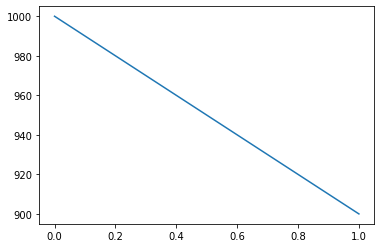

In [58]:
EPSILON = 0.001


def generate_changeover(
    mu_from, mu_to,
    alpha=None,
    delta=None,
    epsilon=EPSILON
):
    if isinstance(alpha, float) and delta is None:
        delta = int((1 / alpha) * np.log((mu_from - mu_to) / epsilon))
    elif alpha is None and isinstance(delta, int):
        alpha = float((1 / delta) * np.log((mu_from - mu_to) / epsilon))
    else:
        raise ValueError(f'Invalid alpha: {alpha} and delta: {delta}')

    for t in range(delta + 1):
        yield mu_to + (mu_from - mu_to) * np.exp(- alpha * t)
        
        
z = np.array(list(generate_changeover(1000, 900, delta=1)))
plt.plot(z)

In [55]:
# The states.
STATES = ['hfo', 'mgo', 'ulsfo', 'vlsfo']

# The dirchlett prior probabilities for each state.
# Reference: https://en.wikipedia.org/wiki/Dirichlet_distribution
PRIOR_PROBABILITY = {
    'hfo': 0.8,
    'mgo': 0.1,
    'ulsfo': 0.05,
    'vlsfo': 0.05,
}

# Saved as from -> to.
TRANSITION_PROBABILITY = {
    'hfo': 
        {'hfo': 0.85, 'mgo': 0.05, 'ulsfo': 0.05, 'vlsfo': 0.05},
    'mgo': 
        {'hfo': 0.1, 'mgo': 0.9, 'ulsfo': 0.0, 'vlsfo': 0.0},
    'ulsfo': 
        {'hfo': 0.1, 'mgo': 0.0, 'ulsfo': 0.9, 'vlsfo': 0.0},
    'vlsfo': 
        {'hfo': 0.1, 'mgo': 0.0, 'ulsfo': 0.0, 'vlsfo': 0.9},
}

# The distribution of the emmision for each state.
STATE_DISTRIBUTION = {
    'hfo': 
        {'mu': 1010, 'sigma': 100},
    'mgo': 
        {'mu': 900, 'sigma': 25},
    'ulsfo': 
        {'mu': 905, 'sigma': 25},
    'vlsfo': 
        {'mu': 910, 'sigma': 25},
}

for from_ in TRANSITION_PROBABILITY:
    assert sum(TRANSITION_PROBABILITY[from_].values()) == 1.0, (
        f'{from_} transition probabilities does not sum to 1.0.'
    )

In [56]:
class Hmm:
    def __init__(
        self,
        states=STATES,
        state_distribution=STATE_DISTRIBUTION,
        prior_probability=PRIOR_PROBABILITY,
        transitions_probability=TRANSITION_PROBABILITY,
    ):
        self.states = states
        self.state_distribution = state_distribution
        self.prior_probability = prior_probability
        self.transitions_probability = transitions_probability
        self.meta_data = {}
        
    def add_changeover(self, from_, to, alpha=None, delta=None):
        new_changeover_state = f"{from_} -> {to}, alpha = {alpha}, delta = {delta}"
        self.meta_data[new_changeover_state] = {
            'from': from_,
            'to': to,
            'changeover': True,
            'alpha': alpha,
            'delta': delta,
        }
        self.states.append(new_changeover_state)
    
    def _generate_changeover(
        self, mu_from, mu_to,
        alpha=None,
        delta=None,
        epsilon=EPSILON
    ):
        if isinstance(alpha, float) and delta is None:
            delta = int((1 / alpha) * np.log((mu_from - mu_to) / epsilon))
        elif alpha is None and isinstance(delta, int):
            alpha = float((1 / delta) * np.log((mu_from - mu_to) / epsilon))
        else:
            raise ValueError(f'Invalid alpha: {alpha} and delta: {delta}')

        for t in range(delta):
            yield mu_to + (mu_from - mu_to) * np.exp(- alpha * t)
        yield mu_to
